In [1]:
%load_ext autoreload
%autoreload 2

from pandas_profiling import ProfileReport
%pylab inline

import warnings
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdmn

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('./data/train_2016_v2.csv')

In [3]:
dtypes = {
    'parcelid': int,
    'airconditioningtypeid': str,
    'architecturalstyletypeid': str,
    'buildingclasstypeid': str,
    'buildingqualitytypeid': str,
    'decktypeid': str,
    'heatingorsystemtypeid': str,
    'pooltypeid10': str,
    'pooltypeid2': str,
    'pooltypeid7': str,
    'regionidcity': str,
    'regionidcounty': str,
    'regionidneighborhood': str,
    'regionidzip': str,
    'typeconstructiontypeid': str,
    'hashottuborspa': str,
    'propertycountylandusecode': str,
    'propertylandusetypeid': str,
    'propertyzoningdesc': str,
    'rawcensustractandblock': str,
    'fireplaceflag': str,
    'taxdelinquencyflag': str,
    'censustractandblock': str,
}

props_df = pd.read_csv('./data/properties_2016.csv', dtype=dtypes)

dtypes.update({
    'fireplacecnt': int,
    'fullbathcnt': int,
    'garagecarcnt': int,
    'poolcnt': int,
    'threequarterbathnbr': int,
    'unitcnt': int,
    'yearbuilt': int,
    'numberofstories': int,
    'structuretaxvaluedollarcnt': int,
    'taxvaluedollarcnt': int,
    'landtaxvaluedollarcnt': int,
    'taxdelinquencyyear': int,
    'roomcnt': int,
    'bedroomcnt': int,
    'assessmentyear': int,
    'fips': int,
})

In [4]:
df_train = df_train.merge(props_df, on='parcelid', how='left')
df_train.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,NaN,NaN,2.0,3.0,NaN,4,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,60371066461001
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,NaN,NaN,3.0,2.0,NaN,4,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,60374638003004
3,12643413,0.0218,2016-01-02,1,NaN,NaN,2.0,2.0,NaN,4,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,60372963002002
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,60590423381006


In [5]:
def log_transf(df):
    if 'structuretaxvaluedollarcnt' in df.columns:
        df.loc[:, 'structuretaxvaluedollarcnt'] = np.log1p(df.structuretaxvaluedollarcnt).copy()
    if 'taxvaluedollarcnt' in df.columns:
        df.loc[:, 'taxvaluedollarcnt'] = np.log1p(df.taxvaluedollarcnt).copy()
    if 'calculatedfinishedsquarefeet' in df.columns:
        df.loc[:, 'calculatedfinishedsquarefeet'] = np.log1p(df.calculatedfinishedsquarefeet).copy()
    if 'lotsizesquarefeet' in df.columns:
        df.loc[:, 'lotsizesquarefeet'] = np.log1p(df.lotsizesquarefeet).copy()
    if 'finishedsquarefeet12' in df.columns:
        df.loc[:, 'finishedsquarefeet12'] = np.log1p(df.finishedsquarefeet12).copy()
    return df

def preprocess(df, rejected_cols=[]):
    drop_cols = set(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc',
                     'propertycountylandusecode']+rejected_cols)
    df = df.copy()
    df['latitude'] = df.latitude / 1e6
    df['longitude'] = df.longitude / 1e6
    
    # From https://www.kaggle.com/nikunjm88/creating-additional-features
    #life of property
    df['N-life'] = (2018 - df['yearbuilt']).fillna(0)

    #proportion of living area
    df['N-LivingAreaProp'] = df['calculatedfinishedsquarefeet']/df['lotsizesquarefeet']
    df['N-LivingAreaProp'] = df['N-LivingAreaProp'].fillna(0)
    df['N-LivingAreaProp2'] = df['N-LivingAreaProp']**2
    df['N-LivingAreaProp2'] = df['N-LivingAreaProp2'].fillna(0)
    df['N-LivingAreaProp3'] = df['N-LivingAreaProp']**3
    df['N-LivingAreaProp3'] = df['N-LivingAreaProp3'].fillna(0)
    df['N-LivingAreaProp-2'] = df['finishedsquarefeet12']/df['finishedsquarefeet15']
    df['N-LivingAreaProp-2'] = df['N-LivingAreaProp-2'].fillna(0)

    #Amout of extra space
    df['N-ExtraSpace'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'] 
    df['N-ExtraSpace'] = df['N-ExtraSpace'].fillna(0)
    df['N-ExtraSpace-2'] = df['finishedsquarefeet15'] - df['finishedsquarefeet12'] 
    df['N-ExtraSpace-2'] = df['N-ExtraSpace-2'].fillna(0)

    #Total number of rooms
    df['N-TotalRooms'] = df['bathroomcnt']*df['bedroomcnt']

    #Average room size
    df['N-AvRoomSize'] = df['calculatedfinishedsquarefeet']/df['roomcnt']
    df.loc[np.isinf(df['N-AvRoomSize'].astype('float32')), 'N-AvRoomSize'] = 0
    df['N-AvRoomSize'] = df['N-AvRoomSize'].fillna(0)

    # Number of Extra rooms
    df['N-ExtraRooms'] = df['roomcnt'] - df['N-TotalRooms'] 

    #Ratio of the built structure value to land area
    df['N-ValueProp'] = (df['structuretaxvaluedollarcnt']/df['landtaxvaluedollarcnt']).fillna(0)

    df['N-ValueProp2'] = df['N-ValueProp']**2
    df['N-ValueProp3'] = df['N-ValueProp']**3
    
    #Does property have a garage, pool or hot tub and AC?
    df['N-GarPoolAC'] = ((df['garagecarcnt'] > 0) &
                         (df['pooltypeid10'] != '0') &
                         (df['airconditioningtypeid'] != '5'))*1 
    drop_cols.add('garagecarcnt')
    
    df["N-location"] = df["latitude"] + df["longitude"]
    df["N-location-2"] = df["latitude"] * df["longitude"]
    df["N-location-2round"] = df["N-location-2"].round(-4)

    df["N-latitude-round"] = df["latitude"].round(-4)
    df["N-longitude-round"] = df["longitude"].round(-4)

    #Ratio of tax of property over parcel
    df['N-ValueRatio'] = (df['taxvaluedollarcnt']/df['taxamount']).fillna(0)
    df['N-ValueRatio2'] = df['N-ValueRatio']**2
    df.loc[np.isinf(df['N-ValueRatio2'].astype('float32')), 'N-ValueRatio2'] = 0
    df['N-ValueRatio3'] = df['N-ValueRatio']**3
    df.loc[np.isinf(df['N-ValueRatio3'].astype('float32')), 'N-ValueRatio3'] = 0

    #TotalTaxScore
    df['N-TaxScore'] = (df['taxvaluedollarcnt']*df['taxamount']).fillna(0)
    df['N-TaxScore2'] = df['N-TaxScore']**2
    df.loc[np.isinf(df['N-TaxScore2'].astype('float32')), 'N-TaxScore2'] = 3.4e38
    df['N-TaxScore3'] = df['N-TaxScore']**3
    df.loc[np.isinf(df['N-TaxScore3'].astype('float32')), 'N-TaxScore3'] = 3.4e38
    
    #Length of time since unpaid taxes
    df['N-taxlife'] = (2018 - df['taxdelinquencyyear']).fillna(0)

    #Number of properties in the zip
    zip_count = df['regionidzip'].value_counts().to_dict()
    df['N-zip_count'] = df['regionidzip'].map(zip_count).fillna(0)

    #Number of properties in the city
    city_count = df['regionidcity'].value_counts().to_dict()
    df['N-city_count'] = df['regionidcity'].map(city_count).fillna(0)

    #Number of properties in the city
    region_count = df['regionidcounty'].value_counts().to_dict()
    df['N-county_count'] = df['regionidcounty'].map(city_count).fillna(0)

    #Indicator whether it has AC or not
    df['N-ACInd'] = (df['airconditioningtypeid']!=5)*1

    #Indicator whether it has Heating or not 
    df['N-HeatInd'] = (df['heatingorsystemtypeid']!=13)*1

    #There's 25 different property uses - let's compress them down to 4 categories
    df['N-PropType'] = df.propertylandusetypeid.replace({
        31 : "Mixed",
        46 : "Other",
        47 : "Mixed",
        246 : "Mixed",
        247 : "Mixed",
        248 : "Mixed",
        260 : "Home",
        261 : "Home",
        262 : "Home",
        263 : "Home",
        264 : "Home",
        265 : "Home",
        266 : "Home",
        267 : "Home",
        268 : "Home",
        269 : "Not Built",
        270 : "Home",
        271 : "Home",
        273 : "Home",
        274 : "Other",
        275 : "Home",
        276 : "Home",
        279 : "Home",
        290 : "Not Built",
        291 : "Not Built"
    })
    drop_cols.add('propertylandusetypeid')


    #polnomials of the variable
    df["N-structuretaxvaluedollarcnt-2"] = df["structuretaxvaluedollarcnt"] ** 2
    df["N-structuretaxvaluedollarcnt-3"] = df["structuretaxvaluedollarcnt"] ** 3

    #Average structuretaxvaluedollarcnt by city
    group = df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
    df['N-Avg-structuretaxvaluedollarcnt'] = df['regionidcity'].map(group)

    #Deviation away from average
    df['N-Dev-structuretaxvaluedollarcnt'] = (abs((df['structuretaxvaluedollarcnt'] -
                                                   df['N-Avg-structuretaxvaluedollarcnt'])) /
                                              df['N-Avg-structuretaxvaluedollarcnt'])

    df['fireplaceflag'] = df.fireplaceflag == 'True'
    df['taxdelinquencyflag'] = df.taxdelinquencyflag == 'Y'
    df['hashottuborspa'] = df.hashottuborspa == 'true'

    df['fireplacecnt'] = df.fireplacecnt.fillna(0).astype(int)
    df['fullbathcnt'] = df.fullbathcnt.fillna(0).astype(int)
    df['garagecarcnt'] = df.garagecarcnt.fillna(0).astype(int)
    df['poolcnt'] = df.poolcnt.fillna(0).astype(int)
    df['threequarterbathnbr'] = df.threequarterbathnbr.fillna(0).astype(int)
    df['unitcnt'] = df.threequarterbathnbr.fillna(0).astype(int)
    df['numberofstories'] = df.numberofstories.fillna(0).astype(int)
    df['numberofstories'] = df.numberofstories.fillna(0).astype(int)
    df['roomcnt'] = df.roomcnt.fillna(0).astype(int)
    df['bedroomcnt'] = df.bedroomcnt.fillna(0).astype(int)
    df['bedroomcnt'] = df.bedroomcnt.fillna(0).astype(int)

    df['fips'] = df.fips.fillna(-1).astype(int)

    df['yearbuilt'] = df.yearbuilt.fillna(np.round(df.yearbuilt.mean())).astype(int)
    df['taxdelinquencyyear'] = df.taxdelinquencyyear.fillna(
        np.round(df.taxdelinquencyyear.mean())
    ).astype(int)
    #polnomials of tax delinquency year
    df["N-taxdelinquencyyear-2"] = df["taxdelinquencyyear"] ** 2
    df["N-taxdelinquencyyear-3"] = df["taxdelinquencyyear"] ** 3
    df['assessmentyear'] = df.assessmentyear.fillna(
        np.round(df.assessmentyear.mean())
    ).astype(int)
    df['structuretaxvaluedollarcnt'] = df.structuretaxvaluedollarcnt.fillna(
        np.round(df.structuretaxvaluedollarcnt.mean())
    ).astype(int)
    df['taxvaluedollarcnt'] = df.taxvaluedollarcnt.fillna(
        np.round(df.taxvaluedollarcnt.mean())
    ).astype(int)
    df['landtaxvaluedollarcnt'] = df.landtaxvaluedollarcnt.fillna(
        np.round(df.landtaxvaluedollarcnt.mean())
    ).astype(int)
    
    # drop columns with std 0
    df = df.drop(['buildingclasstypeid', 'pooltypeid10', 'pooltypeid7',
                  'storytypeid', 'poolcnt', 'assessmentyear'], axis=1, errors='ignore')

    df_cols = df.columns
    df.loc[:, df_cols.str.contains('sqft')] = df.loc[:, df_cols.str.contains('sqft')].fillna(0)
    
    # set nan values in *squarefeet* columns to 0
    df.loc[:, df_cols.str.contains('squarefeet')] = df.loc[:, df_cols.str.contains('squarefeet')].fillna(0)

    
    # fill NaNs in *typeid* columns to -1
    df.loc[:, df_cols.str.contains('typeid')] = df.loc[:, df_cols.str.contains('typeid')].fillna(-1)
    
    # set nan values in *cnt* columns to 0
    df.loc[:, df_cols.str.contains('cnt')] = df.loc[:, df_cols.str.contains('cnt')].fillna(0)
    
    # set NaNs in rest of counts/sums columns to 0
    cols = ['calculatedbathnbr', 'poolsizesum', 'threequarterbathnbr', 'numberofstories']
    df.loc[:, cols] = df.loc[:, cols].fillna(0)

    # set NaNs in rest of id/code columns to 0
    cols = ['regionidcity', 'regionidneighborhood', 'regionidzip', 'censustractandblock']
    df.loc[:, cols] = df.loc[:, cols].fillna(-1)

    # set NaNs in rest of dates columns to mean
    cols = ['yearbuilt', 'taxamount', 'taxdelinquencyyear']
    df.loc[:, cols] = df.loc[:, cols].fillna(df.loc[:, cols].mean())

    drop_cols &= set(df.columns)
    X = df.drop(drop_cols, axis=1).copy()
    y = None
    if 'logerror' in df.columns:
        y = df['logerror'].values.copy()

    for c in X.columns:
        if X[c].dtype == 'object':
            lbl = LabelEncoder()
            X[c] = lbl.fit_transform(list(X[c].values))

    X = log_transf(X)
    X['calculatedfinishedsquarefeet2'] = X['calculatedfinishedsquarefeet']**2
    X['calculatedfinishedsquarefeet3'] = X['calculatedfinishedsquarefeet']**3
    
    return X, y

In [6]:
df_train1, df_test =\
    train_test_split(df_train, test_size=0.2, random_state=0, stratify=np.sign(df_train.logerror))

In [7]:
rejected_cols1 = [
    'calculatedbathnbr',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'finishedsquarefeet6',
    'fullbathcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
]

X_train, y_train = preprocess(df_train1, rejected_cols1)
X_test, y_test = preprocess(df_test, rejected_cols1)

rejected_cols2 = [
    'censustractandblock',
    'typeconstructiontypeid',
    'unitcnt'
]
X_train = X_train.drop(rejected_cols2, axis=1)
X_test = X_test.drop(rejected_cols2, axis=1)

In [8]:
X_train.columns[np.isinf(X_train.astype('float32')).any()]

Index([], dtype='object')

A Jupyter Widget

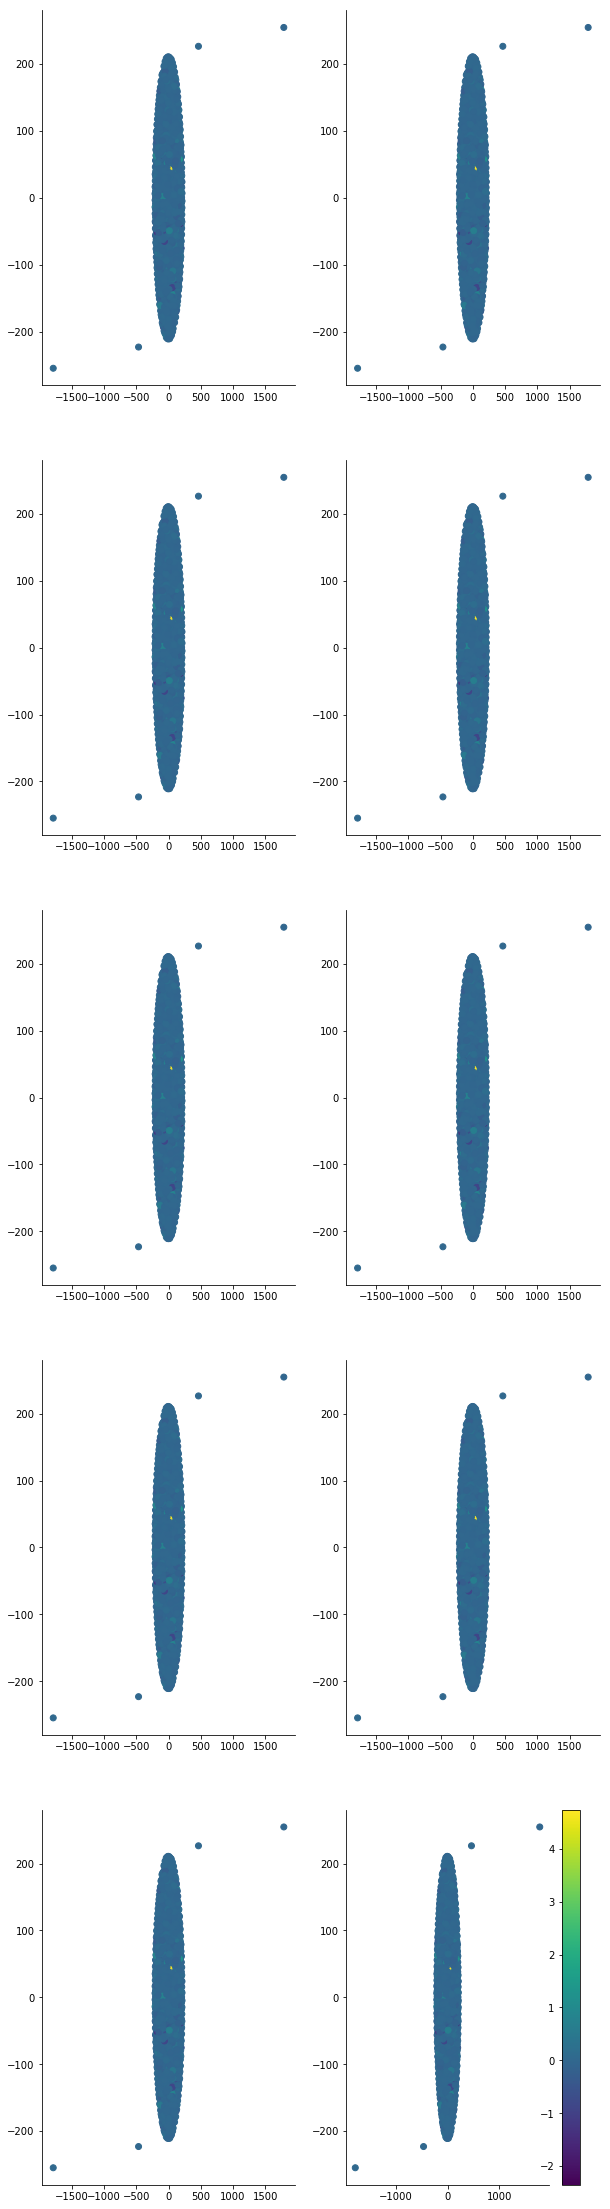

In [17]:
from sklearn.manifold import TSNE

np.random.seed(0)
index_sample = np.random.choice(np.arange(len(X_train)), size=5000, replace=False)

perplexities = [5*i for i in range(1, 11)]
_, axes = plt.subplots(5, 2, figsize=(10, 40))
axes = axes.flatten()
for perplexity, ax in tqdmn(zip(perplexities, axes), total=10):
    tsne = TSNE(verbose=0, random_state=0, perplexity=perplexity)
    t = tsne.fit_transform(X_train.iloc[index_sample].astype('float32'))
    sp = ax.scatter(*t.T, c=y_train[index_sample])
plt.colorbar(sp)
sns.despine()

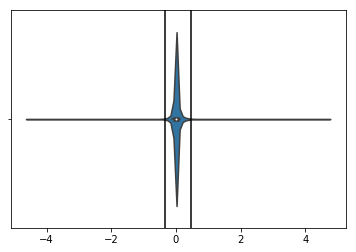

In [18]:
ax = sns.violinplot(x=y_train)
ax.vlines([np.percentile(y_train, 1), np.percentile(y_train, 99)], -1, 1)

In [32]:
len(y_train), len(y_train[(y_train > np.percentile(y_train, 1)) & (y_train < np.percentile(y_train, 99))])

(72220, 70767)

In [21]:
# define two outlier detection tools to be compared
outliers_fraction = 0.05
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(contamination=outliers_fraction,
                                        random_state=0),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

X = np.r_['1,2', X_train, np.atleast_2d(y_train).T]
o_pred = {}
for i, (clf_name, clf) in enumerate(classifiers.items()):
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
    else:
        clf.fit(X)
        y_pred = clf.predict(X)
    o_pred[clf_name] = y_pred

/home/mtambos/anaconda3/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [22]:
for i, clf_name in enumerate(classifiers):
    y_pred = o_pred[clf_name]
    print(f"{clf_name}: {len(y_pred[y_pred == 1])}, {len(y_pred[y_pred != -1])}")

One-Class SVM: 38997, 33223
Robust covariance: 68609, 3611
Isolation Forest: 68609, 3611
Local Outlier Factor: 68609, 3611


A Jupyter Widget

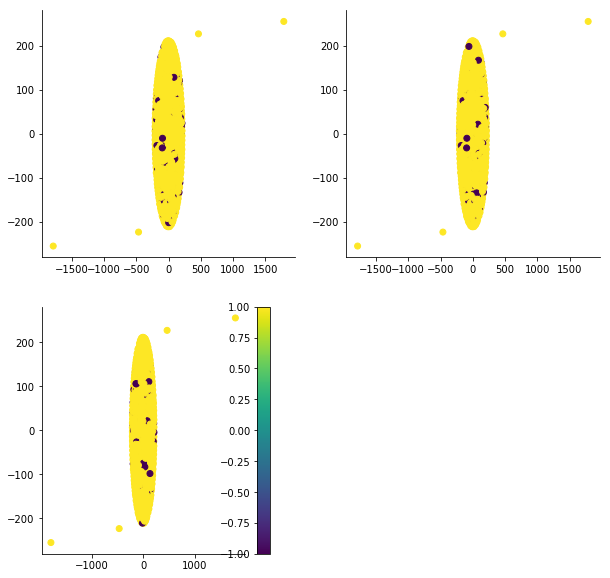

In [23]:
from sklearn.manifold import TSNE

_, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
tsne = TSNE(verbose=0, random_state=0, perplexity=perplexity)
t = tsne.fit_transform(X_train.iloc[index_sample].astype('float32'))
classifiers2 = ['Robust covariance', 'Isolation Forest', 'Local Outlier Factor']

for clf_name, ax in tqdmn(zip(classifiers2, axes), total=3):
    sp = ax.scatter(*t.T, c=o_pred[clf_name][index_sample])

plt.delaxes(axes[-1])
plt.colorbar(sp)
sns.despine()

In [26]:
len(y_pred[y_pred==-1])

3611

A Jupyter Widget

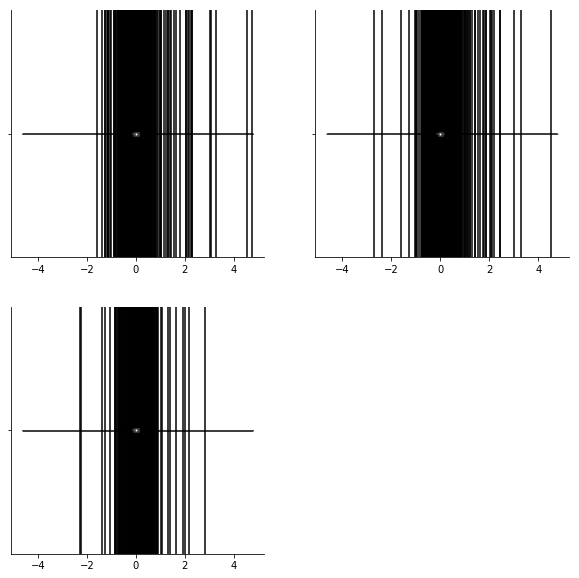

In [30]:
_, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
classifiers2 = ['Robust covariance', 'Isolation Forest', 'Local Outlier Factor']

for clf_name, ax in tqdmn(zip(classifiers2, axes), total=3):
    sns.violinplot(x=y_train, ax=ax)
    y_pred = o_pred[clf_name]
    ax.vlines(y_train[y_pred==-1], -1, 1)
plt.delaxes(axes[-1])
sns.despine()
